In [201]:
import importlib
import data_preprocessor
import helper_functions
import cluster_validation as cv
import cluster_plotting as cp
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

importlib.reload(data_preprocessor)
importlib.reload(helper_functions)
importlib.reload(cv)
importlib.reload(cp)

from helper_functions import load_dataset, save_dataset, save_cluster_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from data_preprocessor import DataPreprocessor
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, BisectingKMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [202]:
data_original = load_dataset("../data/assignment3_articles.xlsx")

## 1) Data Inspection and Preparation

First, we do some basic inspection of the dataset, such as checking the first few rows, the data types, the amount of missing values, and the value counts of certain columns.

In [203]:
data_original

,index,headlines,description,content
0,0,Rupee ends 1 paisa lower at 83.38 against US dollar,"Besides, selling pressure in the domestic equity markets dented market sentiments, forex traders said.","The rupee consolidated in a narrow range and settled 1 paisa lower at 83.38 (provisional) against the US dollar on Tuesday, as investors preferred to remain cautious ahead of the domestic inflation data release and upcoming US Fed meeting.\nBesides, selling pressure in the domestic equity markets dented market sentiments, forex traders said.\nHowever, a weaker American currency against major currencies overseas restricted the loss in the local currency, they added.\nADVERTISEMENT\nAt the interbank foreign exchange market, the local unit opened at 83.36 and settled at 83.38 (provisional) against the greenback, registering a loss of 1 paisa from its previous close.\nDuring intra-day, the rupee touched a high of 83.35 and hit the lowest level of 83.39.\nOn Monday, the domestic currency settled at 83.37 against the US dollar.\nInvestors largely remained concerned over the domestic inflation data as well as industrial production numbers to be announced later in the day.\nADVERTISEMENT\nCurrency traders were also awaiting the US Federal Reserve’s monetary policy decision likely to be announced later this week.\n“The upcoming focus is on the US CPI data in the evening, with expectations of 0.3 per cent on a month-on-month basis and a lower year-on-year figure at 3.1 per cent. Anticipating mixed reactions, the rupee seems unaffected, persisting within the broad range of 83.30-83.45,” Jateen Trivedi, VP Research Analyst at LKP Securities, said.\nMeanwhile, the dollar index, which gauges the greenback’s strength against a basket of six currencies, was trading 0.28 per cent lower at 103.41 on Tuesday.\nADVERTISEMENT\nBrent crude futures, the global oil benchmark, advanced 0.34 per cent to USD 76.29 per barrel.\nOn the domestic equity market front, the 30-share benchmark BSE Sensex plunged 377.50 points, or 0.54 per cent, to settle at 69,551.03 points. The Nifty also fell 90.70 points, or 0.43 per cent, to 20,906.40 points.\nForeign Institutional Investors (FIIs) were net buyers in the capital market on Monday as they bought shares worth Rs 1,261.13 crore, according to exchange data."
1,1,"India vs Syria Live Streaming, AFC Asian Cup 2023: When and where to watch match live","AFC Asian Cup Live Streaming, India vs Syria Football Match: India currently stand at the bottom of Group B, having lost their first two matches against Australia (0-2) and Uzbekistan (0-3).","India vs Syria AFC Asia Cup Live Streaming Details: India will take on Syria in a do-or-die match in their last game of Group B at the AFC Asian Cup. India currently stand at the bottom of Group B, having lost their first two matches against Australia (0-2) and Uzbekistan (0-3).\nThe four best third-placed teams from six groups, along with the top two teams from each group, will make it to the round of 16. For India, the equation is that they must get three points against Syria to secure the third spot and hope for the results in the other groups to go in their favour.\nYou have exhausted your monthly limit of free stories.\nRegister to read more stories\nContinue With:-\nGoogle\nFacebook\nEmail\nAlready have an account? Sign in"
2,2,"PM Modi to interact with VCs, teachers, students at UGC’s G20 University Connect event",G20 University Connect: The commission has asked the universities and colleges of the National Capital Region (NCR) to participate in the event by nominating around 30 to 40 students and two faculty members to attend the event.,"The University Grants Commission (UGC) is organising a university connect event on September 26, 2023 at New Delhi. As part of the event, Prime Minister Narendra Modi will interact with the Vice-Chancellors, principals, faculty members and students of the universities and colleges at Bharat Mandapam. \nAlthough the programme is scheduled to 

In [204]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        2500 non-null   int64 
 1   headlines    2500 non-null   object
 2   description  2500 non-null   object
 3   content      2500 non-null   object
dtypes: int64(1), object(3)
memory usage: 78.2+ KB


### Preprocessing the text data

In [205]:
# Initialize the DataPreprocessor object
preprocessor = DataPreprocessor()

We quickly how below how the preprocessor works by applying it to the first row of the content column.

In [206]:
# get first row and last column
data_original.iloc[0, -1]

'The rupee consolidated in a narrow range and settled 1 paisa lower at 83.38 (provisional) against the US dollar on Tuesday, as investors preferred to remain cautious ahead of the domestic inflation data release and upcoming US Fed meeting.\nBesides, selling pressure in the domestic equity markets dented market sentiments, forex traders said.\nHowever, a weaker American currency against major currencies overseas restricted the loss in the local currency, they added.\nADVERTISEMENT\nAt the interbank foreign exchange market, the local unit opened at 83.36 and settled at 83.38 (provisional) against the greenback, registering a loss of 1 paisa from its previous close.\nDuring intra-day, the rupee touched a high of 83.35 and hit the lowest level of 83.39.\nOn Monday, the domestic currency settled at 83.37 against the US dollar.\nInvestors largely remained concerned over the domestic inflation data as well as industrial production numbers to be announced later in the day.\nADVERTISEMENT\nCur

In [207]:
preprocessor.preprocess_text(data_original.iloc[0, -1])

'rupe consolid narrow rang settl paisa lower provision us dollar tuesday investor prefer remain cautiou ahead domest inflat data releas upcom us fed meet besid sell pressur domest equiti market dent market sentiment forex trader said howev weaker american currenc major currenc oversea restrict loss local currenc ad interbank foreign exchang market local unit open settl provision greenback regist loss paisa previou close intraday rupe touch high hit lowest level monday domest currenc settl us dollar investor larg remain concern domest inflat data well industri product number announc later day currenc trader also await us feder reserv monetari polici decis like announc later week upcom focu us cpi data even expect per cent monthonmonth basi lower yearonyear figur per cent anticip mix reaction rupe seem unaffect persist within broad rang jateen trivedi vp research analyst lkp secur said meanwhil dollar index gaug greenback strength basket six currenc trade per cent lower tuesday brent cru

### Data Preprocessing

In [208]:
def count_numbers(text):
    """
    Count the occurrences of numbers in the text.
    """
    # match numbers
    pattern = r'\b\d+[,.]\d+\b|\b\d+[,.]?\b|\b[,.]\d+\b'
    return len(re.findall(pattern, text))

def count_integers(text):
    """
    Count the occurrences of integers in the text.
    """
    # match integers
    pattern = r'(?<![\.,])\b\d+\b(?![\.,])'
    return len(re.findall(pattern, text))

def count_floats(text):
    """
    Count the occurrences of floating point numbers in the text.
    """
    # match floating point numbers
    pattern = r'\b\d+[\.,]\d+\b'
    return len(re.findall(pattern, text))

def preprocess_col(preprocessor: DataPreprocessor, col: pd.Series, h_pct: float = 0, l_pct: float = 0) -> pd.Series:
    """ 
    Preprocesses a column of text data using the preprocessor (cfr. data_preprocessor.py), 
    and by removing the top $h_pct of the most frequent words and the top $l_pct of the least frequent words.
    
    Inspired partly by: https://medium.com/analytics-vidhya/introduction-to-text-classification-in-python-659eccf6b2e
    
    :param preprocessor: preprocessor object
    :param col: column of text data
    :param h_pct: "the percentage of high frequency words to remove from the corpus"
    :param l_pct: "the percentage of low frequency words to remove from the corpus"
    :return: preprocessed column
    """

    col = col.apply(preprocessor.preprocess_text)
    
    if h_pct != 0:
        #removing the top $h_pct of the most frequent words 
        high_freq = pd.Series(' '.join(col).split()).value_counts()[:int(pd.Series(' '.join(col).split()).count()*h_pct/100)]
        rem_high = col.apply(lambda x: " ".join(x for x in x.split() if x not in high_freq))
    else:
        rem_high = col
    
    if l_pct != 0:
        #removing the top $l_pct of the least frequent words
        low_freq = pd.Series(' '.join(rem_high).split()).value_counts()[:-int(pd.Series(' '.join(rem_high).split()).count()*l_pct/100):-1]
        rem_low = rem_high.apply(lambda x: " ".join(x for x in x.split() if x not in low_freq))
    else:
        rem_low = rem_high
    
    return rem_low

We concatenate the headlines, descriptions, and preprocessed content columns into a single column, and preprocess the concatenated column.

In [209]:
data = data_original.copy()
# count amount of numbers in content column
data['amount_of_integers'] = data['content'].apply(count_integers)
data['amount_of_floats'] = data['content'].apply(count_floats)

# remove news site subscriber stuff, I got this from Inte Vleminckx. We were in call while he was going through the dataset for these:

data = data.replace("""Register to read more stories
Continue With:-
Google
Facebook
Email
Already have an account? Sign in""", '')
data = data.replace('Click for more updates and latest Bollywood news along with Entertainment updates. Also get latest news and top headlines from India and around the world at The Indian Express.', '')
data = data.replace("""(‘My dear students’, a fortnightly column that is a conversation with young minds on current events, books, popular culture — just about anything that’s worth talking over a cup of coffee.)
My dear students,
This story is subscriber only!

Now subscribe at a special discount of 15% Use Code: ELECTION15
Subscribe Now
Already a subscriber? Sign in""", '')
data = data.replace("""This premium article is free for now..
Register to continue reading.
Register""", '')
data = data.replace('Already a subscriber? Sign in', '')
data = data.replace('Already have an account? Sign in', '')
data = data.replace('You have exhausted your monthly limit of free stories.', '')
data = data.replace('CLICK HERE FOR MORE', '')
data = data.replace('BUY NOW', '')
data['content'] = data['content'].replace('Register', '')

data['preprocessed_content'] = preprocess_col(preprocessor, data['content'], h_pct=1, l_pct=1)
data['concatenated'] = data['headlines'] + ' ' + data['description'] + ' ' + data['preprocessed_content']
data['preprocessed_concat'] = preprocess_col(preprocessor, data['concatenated'], h_pct=0, l_pct=0)

data_preprocessed = data.drop(columns=['headlines', 'description', 'content', 'preprocessed_content', 'concatenated'])

In [210]:
data_preprocessed

,index,amount_of_integers,amount_of_floats,preprocessed_concat
0,0,3,21,rupe end paisa lower us dollar besid sell pressur domest equiti market dent market sentiment forex trader said paisa cautiou dent weaker paisa monthonmonth unaffect jateen trivedi vp lkp
1,1,4,0,india vs syria live stream afc asian cup watch match live afc asian cup live stream india vs syria footbal match india current stand bottom group b lost first two match australia uzbekistan syria afc syria doordi afc bottom uzbekistan thirdplac syria
2,2,3,0,pm modi interact vc teacher student ugc univers connect event univers connect commiss ask univers colleg nation capit region ncr particip event nomin around student two faculti member attend event vicechancellor princip mandapam vicechancellor princip
3,3,0,0,remov bloatwar app samsung realm xiaomi vivo redmi smartphon smartphon compani often ship android phone preinstal app might never use here remov disabl regain system resourc bloatwar candi crush saga useless uninst bloatwar disabl bloatwar
4,4,2,0,neet ss result declar counsel schedul soon natboardeduin neet ss result candid appear exam check scorecard offici websit natboardeduin nbem eligibilitycumentr specialti ss scorecard natboardeduin ss dm mch drnb specialti
...,...,...,...,...
2495,2495,0,0,googl search len visualis stem model help calculu solv math problem googl search len help student equat geometri problem offer stepbystep explan solv len bunch math visuali len stepbystep explan math solver
2496,2496,1,0,arsen partey injuri doubt arteta reli jorginho leadership partey came halftim arsen fa cup loss manchest citi last week arteta said time need undergo mri scan ghanaian reveal could continu partey discomfort rib mikel partey halftim mri scan ghanaian unusu elneni jorginho inconveni mo circumst goodison sean dych gabriel martinelli concert bukayo saka william saliba whenev
2497,2497,9,0,iqoo get android updat hot app hot game iqoo say upcom flagship phone run funtouch os base android wont hot app hot game iqoo iqoo snapdragon funtouch os iqoo nipun marya patchesthi os
2498,2498,1,0,lava blaze pro review best phone rs lava blaze pro excel smartphon break bank lava lure blaze lava blaze highend gigabitclass lava blaze realworld


We vectorize the preprocessed text data using the TF-IDF method.

In [211]:
vectorizer = TfidfVectorizer(min_df=5)
# vectorizer = CountVectorizer()
vectorized_data = vectorizer.fit_transform(data_preprocessed['preprocessed_concat']) # Vectorize preprocessed text data
vectorized_data_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_features = vectorized_data_df.copy()

In [212]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# number_of_integers_scaled = scaler.fit_transform(data_preprocessed[['amount_of_integers']])
# number_of_floats_scaled = scaler.fit_transform(data_preprocessed[['amount_of_floats']])
# Combine TF-IDF features with the normalized count columns
# combined_features = np.hstack((tfidf_features, number_of_integers_scaled, number_of_floats_scaled))
# tfidf_features = pd.DataFrame(combined_features, columns=list(vectorizer.get_feature_names_out()) + ['amount_of_integers', 'amount_of_floats'])

In [213]:
tfidf_features

aaa  aamir   ab  abandon  abc  abhishek  abil  abl  abraham  abrar  \
0     0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0   
1     0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0   
2     0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0   
3     0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0   
4     0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0   
...   ...    ...  ...      ...  ...       ...   ...  ...      ...    ...   
2495  0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0   
2496  0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0   
2497  0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0   
2498  0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0   
2499  0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0   

      abroad  absenc  absent  absorb  abu  abus  academ  academi  acc  accept  \
0        0.0     0.0     0.0     0.0  0.0   0.0     0.0      0.0  0.0     0.0   
1        0.0     0.0     0.0     0.0  0.0   0.0     0.0      0.0  0.0     0.0   
2        0.0     0.0     0.0     0.0  0.0   0.0     0.0      0.0  0.0     0.0   
3        0.0     0.0     0.0     0.0  0.0   0.0     0.0      0.0  0.0     0.0   
4        0.0     0.0     0.0     0.0  0.0   0.0     0.0      0.0  0.0     0.0   
...      ...     ...     ...     ...  ...   ...     ...      ...  ...     ...   
2495     0.0     0.0     0.0     0.0  0.0   0.0     0.0      0.0  0.0     0.0   
2496     0.0     0.0     0.0     0.0  0.0   0.0     0.0      0.0  0.0     0.0   
2497     0.0     0.0     0.0     0.0  0.0   0.0     0.0      0.0  0.0     0.0   
2498     0.0     0.0     0.0     0.0  0.0   0.0     0.0      0.0  0.0     0.0   
2499     0.0     0.0     0.0     0.0  0.0   0.0     0.0      0.0  0.0     0.0   

      access  accompani  accomplish  accord  accordingli  account  accredit  \
0        0.0        0.0         0.0     0.0          0.0      0.0       0.0   
1        0.0        0.0         0.0     0.0          0.0      0.0       0.0   
2        0.0        0.0         0.0     0.0          0.0      0.0       0.0   
3        0.0        0.0         0.0     0.0          0.0      0.0       0.0   
4        0.0        0.0         0.0     0.0          0.0      0.0       0.0   
...      ...        ...         ...     ...          ...      ...       ...   
2495     0.0        0.0         0.0     0.0          0.0      0.0       0.0   
2496     0.0        0.0         0.0     0.0          0.0      0.0       0.0   
2497     0.0        0.0         0.0     0.0          0.0      0.0       0.0   
2498     0.0        0.0         0.0     0.0          0.0      0.0       0.0   
2499     0.0        0.0         0.0     0.0          0.0      0.0       0.0   

      accumul  accur  accuraci  accus  achiev  acknowledg  acquir  across  \
0         0.0    0.0       0.0    0.0     0.0         0.0     0.0     0.0   
1         0.0    0.0       0.0    0.0     0.0         0.0     0.0     0.0   
2         0.0    0.0       0.0    0.0     0.0         0.0     0.0     0.0   
3         0.0    0.0       0.0    0.0     0.0         0.0     0.0     0.0   
4         0.0    0.0       0.0    0.0     0.0         0.0     0.0     0.0   
...       ...    ...       ...    ...     ...         ...     ...     ...   
2495      0.0    0.0       0.0    0.0     0.0         0.0     0.0     0.0   
2496      0.0    0.0       0.0    0.0     0.0         0.0     0.0     0.0   
2497      0.0    0.0       0.0    0.0     0.0         0.0     0.0     0.0   
2498      0.0    0.0       0.0    0.0     0.0         0.0     0.0     0.0   
2499      0.0    0.0       0.0    0.0     0.0         0.0     0.0     0.0   

      act  action  activ  actor  actorproduc  actress   ad  adam  adani  \
0     0.0     0.0    0.0    0.0          0.0      0.0  0.0   0.0    0.0   
1     0.0     0.0    0.0    0.0          0.0      0.0  0.0   0.0    0.0   
2     0.0     0.0    

In [214]:
from sklearn.decomposition import LatentDirichletAllocation

# Fit LDA model
n_topics = 5  # Number of topics to extract
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(vectorized_data)

# Get the topic distribution for each document
topic_distribution = lda.transform(vectorized_data)
d = data.copy()
d['topic'] = np.argmax(topic_distribution, axis=1)

In [215]:
d['topic'].value_counts()

topic
2    811
1    681
0    382
3    377
4    249
Name: count, dtype: int64

In [216]:
# Print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

n_top_words = 20
print("Topics in LDA model:")
tf_feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)

# Count the number of articles for each topic
topic_counts = d['topic'].value_counts()
print("Number of articles per topic:")
print(topic_counts)

Topics in LDA model:
Topic #0:
test vs cuet australia india cricket world kohli ind khan cup team au virat play run women pakistan first sharma
Topic #1:
rs per cent crore india market share point tech new us news sensex price galaxi bank launch trade watch sale
Topic #2:
exam result student ug univers offici check websit class neet candid year board releas india iit jee counsel programm new
Topic #3:
film shah rukh khan box collect offic day kapoor ai rs anim dunki crore salaar ranbir new director year make
Topic #4:
kapoor khan boss india bigg gold fund say anim watch ranbir said game nanda rs mandanna ira video ankita bank

Number of articles per topic:
topic
2    811
1    681
0    382
3    377
4    249
Name: count, dtype: int64


### Clustering

In [217]:
RANDOM_STATE = 42
DIM_REDUCTION_COMPONENTS = 20
MAX_K = 12
STATISTICS_N_PERMUTATIONS = 10
NUM_CLUSTERS = 5 # set after elbow method and others

### KMedoids

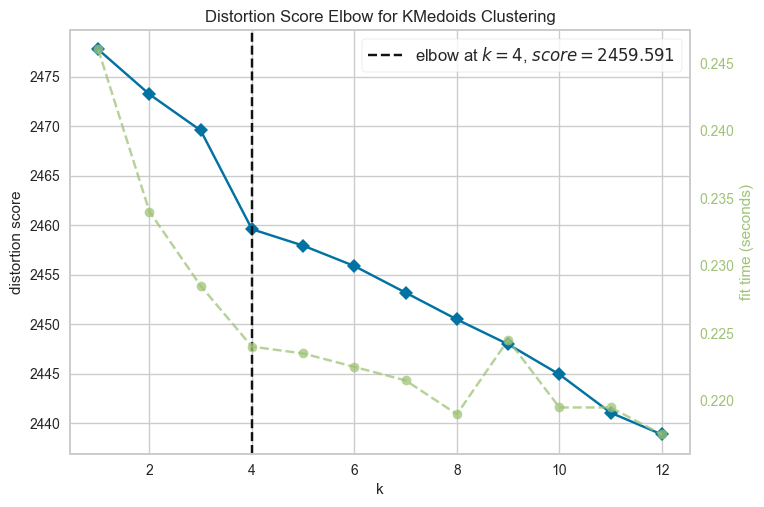

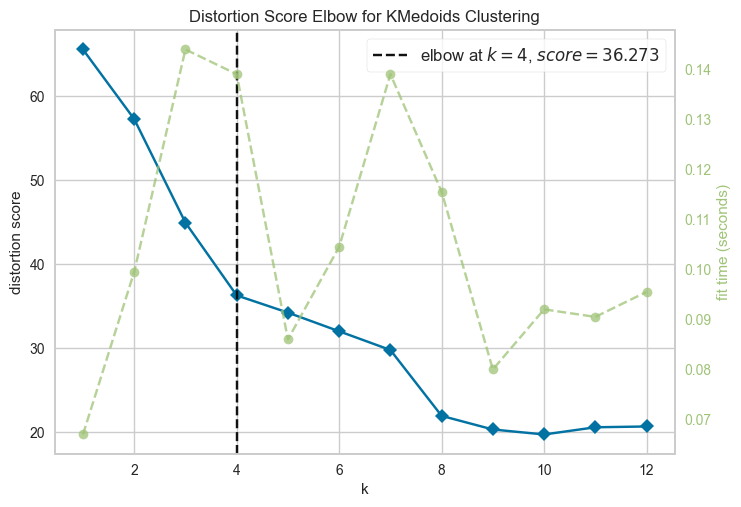

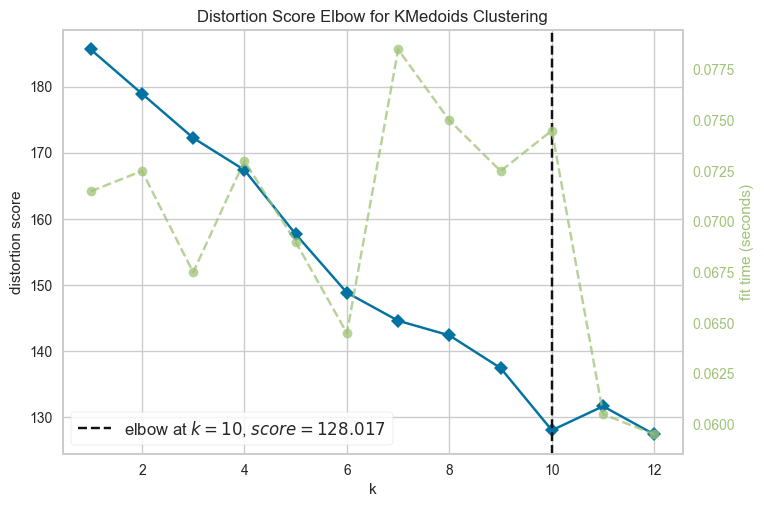

In [218]:
cp.elbow_method_plot(KMedoids(random_state=RANDOM_STATE, metric='cosine'), vectorized_data_df, max_k=MAX_K)
cp.elbow_method_plot(KMedoids(random_state=RANDOM_STATE, metric='cosine'),TruncatedSVD(n_components=5, random_state=RANDOM_STATE).fit_transform(tfidf_features), max_k=MAX_K)
cp.elbow_method_plot(KMedoids(random_state=RANDOM_STATE, metric='cosine'), TruncatedSVD(n_components=DIM_REDUCTION_COMPONENTS, random_state=RANDOM_STATE).fit_transform(tfidf_features), max_k=MAX_K)

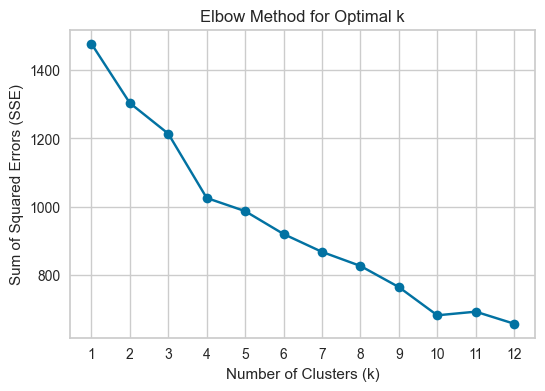

In [219]:
sse = []  # List to store SSE values for different k
n_init = 50
max_k = MAX_K
for k in range(1, max_k + 1):
    best_inertia = float('inf')
    for i in range(n_init):
        random_state = i
        model_k = KMedoids(n_clusters=k, random_state=RANDOM_STATE, metric='cosine', init='k-medoids++')
        model_k.fit(TruncatedSVD(n_components=DIM_REDUCTION_COMPONENTS, random_state=RANDOM_STATE).fit_transform(tfidf_features))
        if model_k.inertia_ < best_inertia:
          best_inertia = model_k.inertia_
    sse.append(best_inertia)

# Plot SSE vs. number of clusters (k)
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_k + 1), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

In [220]:
def run_kmedoids_multiple_times(data, num_clusters, num_runs, metric='cosine', init='k-medoids++'):
    """
    Run KMedoids clustering multiple times and keep track of the best model using SSE.
    :param model: KMedoids model
    :param data: data to cluster
    :param num_clusters: number of clusters
    :param num_runs: number of runs
    :param random_state: random state
    :param verbose: print results
    :return: best model
    """
    models = []
    for i in range(num_runs):
        random_state = i
        model = KMedoids(n_clusters=num_clusters, metric=metric, random_state=random_state, init=init)
        model.fit(data)
        cluster_labels = model.labels_
        sse = model.inertia_
        
        # Calculate label counts and standard deviation of the counts
        label_counts = np.bincount(cluster_labels)
        max_count = label_counts.max()
        std_dev = np.std(label_counts)
        
        # Only save the model if the highest count of any label does not exceed 700
        if max_count <= 700:
            models.append((model, cluster_labels, sse, std_dev))
            
    # Sort the models by standard deviation of label counts in ascending order
    models.sort(key=lambda x: x[2])
    # Print the results
    for m in models:
        kmedoids, cluster_labels, sse, std_dev = m
        print(f"Model: {kmedoids} SSE: {sse}")
        print(f"Label Distribution: {' '.join([f'{i}: {v}' for i, v in enumerate(np.bincount(cluster_labels))])}")
        print(f"Standard Deviation of Label Counts: {std_dev:.2f}")
        print()

In [221]:
run_kmedoids_multiple_times(TruncatedSVD(n_components=20, random_state=42).fit_transform(tfidf_features), num_clusters=5, num_runs=300, metric='cosine', init='k-medoids++')

Model: KMedoids(init='k-medoids++', metric='cosine', n_clusters=5, random_state=273) SSE: 915.6791813260361
Label Distribution: 0: 535 1: 456 2: 629 3: 484 4: 396
Standard Deviation of Label Counts: 78.58

Model: KMedoids(init='k-medoids++', metric='cosine', n_clusters=5, random_state=12) SSE: 924.1046769874922
Label Distribution: 0: 545 1: 497 2: 390 3: 449 4: 619
Standard Deviation of Label Counts: 78.61

Model: KMedoids(init='k-medoids++', metric='cosine', n_clusters=5, random_state=91) SSE: 924.1046769874922
Label Distribution: 0: 390 1: 545 2: 619 3: 449 4: 497
Standard Deviation of Label Counts: 78.61

Model: KMedoids(init='k-medoids++', metric='cosine', n_clusters=5, random_state=142) SSE: 924.1046769874922
Label Distribution: 0: 449 1: 390 2: 545 3: 497 4: 619
Standard Deviation of Label Counts: 78.61

Model: KMedoids(init='k-medoids++', metric='cosine', n_clusters=5, random_state=157) SSE: 924.1046769874922
Label Distribution: 0: 497 1: 545 2: 449 3: 390 4: 619
Standard Deviat

In [222]:
run_kmedoids_multiple_times(TruncatedSVD(n_components=20, random_state=42).fit_transform(tfidf_features), num_clusters=5, num_runs=300, metric='jaccard', init='k-medoids++')

In [223]:
def kmedoids_clustering(df, num_clusters, random_state, init='k-medoids++', plot=False, precomputed=False, metric='euclidean', n_permutations=STATISTICS_N_PERMUTATIONS):
    """
    Perform Kmedoids clustering on the dataset.
    :param df: 
    :param n_clusters: 
    :param random_state: 
    :param n_init: 
    :param init: 
    :param plot: 
    :param precomputed: 
    :param metric: 
    :param n_permutations: 
    :return: 
    """
    bkmeans = KMedoids(n_clusters=num_clusters, random_state=random_state, init=init, metric=metric)
    bkmeans.fit(df)
    cluster_labels = bkmeans.labels_

    # Assign cluster labels to documents in the dataset
    labels = tfidf_features.copy()
    labels['cluster'] = cluster_labels

    print(labels['cluster'].value_counts())
    
    stats_bkm = cv.cv_statistics(bkmeans, cluster_labels, df, num_clusters, metric=metric, n_permutations=n_permutations, verbose=False)
    
    cv.cv_similarity_matrix(df, cluster_labels, metric=metric, precomputed=precomputed)
    
    if plot:
        cp.plot_clusters_2d_all(df.values, cluster_labels)
        cp.plot_clusters_3d_all(df.values, cluster_labels)
    
    return bkmeans, cluster_labels

cluster
0    933
2    681
1    462
3    244
4    180
Name: count, dtype: int64
---
Actual Inertia: 2342.8649
Random Inertia: Mean: 2400.7113, Std: 6.1113
Inertia Z-Score: -9.4655 => Inertia is Atypical: True
---
Actual Silhouette Score: 0.0032
Random Silhouette: Mean: -0.0033, Std: 0.0022
Silhouette Z-Score: 2.9222 => Silhouette Score is Atypical: True
---
Actual Correlation: -0.1070
Random Correlation: Mean: -0.0467, Std: 0.0035
Correlation Z-Score: -17.1323 => Correlation is Atypical: True
---


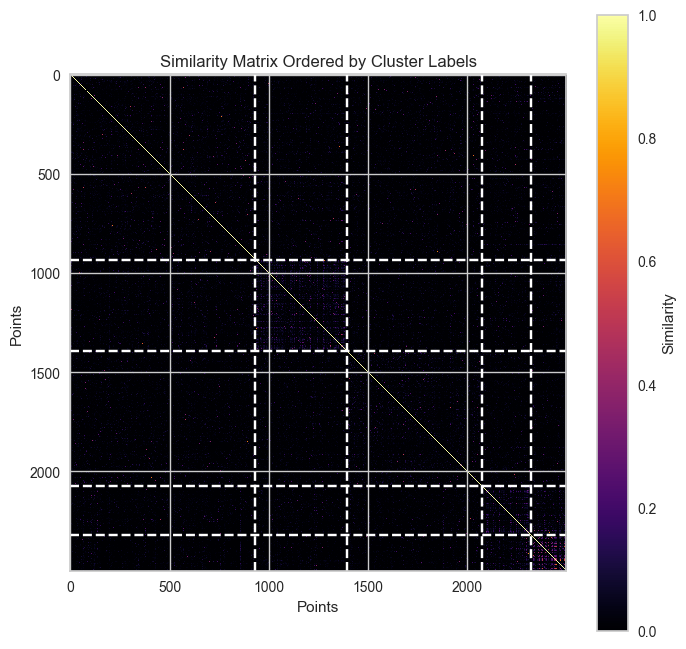

In [224]:
kmedoids1, labels1 = kmedoids_clustering(tfidf_features, num_clusters=5, random_state=279, plot=False, metric='cosine')

cluster
4    625
0    525
1    506
2    436
3    408
Name: count, dtype: int64
---
Actual Inertia: 940.1418
Random Inertia: Mean: 1346.9453, Std: 25.3161
Inertia Z-Score: -16.0689 => Inertia is Atypical: True
---
Actual Silhouette Score: 0.0387
Random Silhouette: Mean: 0.0244, Std: 0.0070
Silhouette Z-Score: 2.0496 => Silhouette Score is Atypical: True
---
Actual Correlation: -0.4551
Random Correlation: Mean: -0.2352, Std: 0.0257
Correlation Z-Score: -8.5615 => Correlation is Atypical: True
---


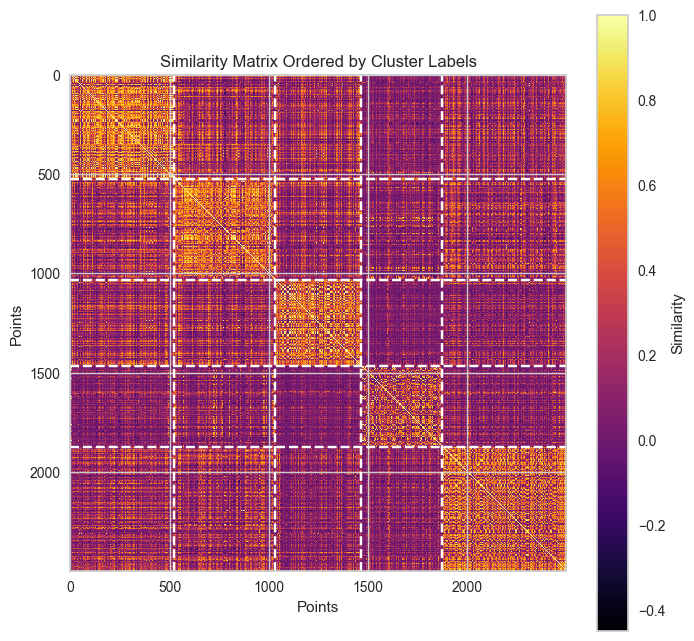

In [225]:
kmedoids2, labels2 = kmedoids_clustering(TruncatedSVD(n_components=num_components, random_state=RANDOM_STATE).fit_transform(tfidf_features), num_clusters=5, random_state=279, plot=False, metric='cosine', init='random')
save_cluster_labels(data_original, labels2, '../output/cluster_assignments/kmedoids_1.xlsx')

In [229]:
kmedoids3, labels3 = kmedoids_clustering(tfidf_features, num_clusters=5, random_state=279, plot=False, metric='jaccard', init='k-medoids++')

cluster
0    878
4    645
2    497
3    377
1    103
Name: count, dtype: int64
---
Actual Inertia: 2382.7483
Random Inertia: Mean: 2428.7721, Std: 3.1429
Inertia Z-Score: -14.6436 => Inertia is Atypical: True
---
Actual Silhouette Score: 0.0031
Random Silhouette: Mean: -0.0029, Std: 0.0025
Silhouette Z-Score: 2.4041 => Silhouette Score is Atypical: True
---
Actual Correlation: nan
Random Correlation: Mean: nan, Std: nan
Correlation Z-Score: nan => Correlation is Atypical: False
---


AttributeError: 'DataFrame' object has no attribute 'dtype'